### Names:
Mackenzie Campbell, Kaylee Chung Young Cheong, Nicole Nielsen, Yale Wang


# Project Proposal

### Title: 
Top Tennis Players: Relationship Between Rank and Age


### Introduction: 
For this project, we plan to analyse some of the top tennis players in the world in order to create a model for predicting player performance based on their age. Factors such as age likely contribute to the ability of players to succeed at tennis. Younger players may not have had as much time to train or experience on the court, while older players might not be as physically fit, so it would be very interesting to find out how ages correlate with ranks.

Our question is: “How do a player’s age correlate with their overall rank, and can rank accurately be predicted based off of a new player’s age?”

We will use the tennis dataset “Player Stats for Top 500 Players” to answer our question. The dataset contains various statistics on top tennis players in the world, including names, ages, countries and their various different rankings such as elo ranks/ratings, goat ranks/ratings, and titles such as grand slams and olympics.

### Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(stringi)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**Step 1: reading and tidying the data**

In [2]:
#loading dataset
players_url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
player_stats <- read_csv(players_url)

#tidying column names
names(player_stats) <- gsub(" ", "_", names(player_stats)) %>%
                        tolower()

#tidying "active" column
player_stats$active[is.na(player_stats$active)] <- "No"

tidy_player_stats <- player_stats %>%
        
    #separating columns with multiple variables
        separate(age, sep = " ", into = c("age", "birthdate"), convert = TRUE) %>%
                        
        separate(current_rank, sep = " ", into = c("current_rank", "current_rating"), convert = TRUE) %>%
        separate(best_rank, sep = " ", into = c("best_rank", "best_rank_date"), convert = TRUE) %>%
                        
        separate(favorite_surface, sep = " ", into = c("favorite_surface", "favorite_surface_percent")) %>%
        
        separate(current_elo_rank, sep = " ", into = c("current_elo_rank", "current_elo_rating"), convert = TRUE) %>% 
        separate(best_elo_rank, sep = " ", into = c("best_elo_rank", "best_elo_rank_date"), convert = TRUE) %>%

        separate(peak_elo_rating, sep = " ", into = c("peak_elo_rating", "peak_elo_rating_date"), convert = TRUE) %>%

        separate(goat_rank, sep = " ", into = c("goat_rank", "goat_rating"), convert = TRUE) %>%

    #further tidying (e.g. removing brackets, changing data type)
        mutate(current_rating = parse_number(current_rating), 
                best_rank_date = str_replace(best_rank_date, "[(]", ""), best_rank_date = str_replace(best_rank_date, "[)]", ""), best_rank_date = as.Date(best_rank_date, format = '%d-%m-%Y'),
                height_cm = parse_number(height), weight_kg = parse_number(weight), prize_money = parse_number(prize_money), 
                current_elo_rating = parse_number(current_elo_rating),
                best_elo_rank_date = str_replace(best_elo_rank_date, "[(]", ""), best_elo_rank_date = str_replace(best_elo_rank_date, "[)]", ""), best_elo_rank_date = as.Date(best_elo_rank_date, format = '%d-%m-%Y'),
                peak_elo_rating_date = str_replace(peak_elo_rating_date, "[(]", ""), peak_elo_rating_date = str_replace(peak_elo_rating_date, "[)]", ""), peak_elo_rating_date = as.Date(peak_elo_rating_date, format = '%d-%m-%Y'),
                last_appearance = as.Date(last_appearance, format = '%d-%m-%Y'),
                goat_rating = parse_number(goat_rating),
                active = as.factor(active)) %>%
    
    #selecting columns to plot against current_rank
        select(-x1, -wikipedia, -name, -facebook, -twitter, -nicknames, -birthdate, -coach, -web_site, -height, -weight, -favorite_surface_percent, -birthplace, -residence) %>%
                        
        arrange(current_rank) %>%
        filter(!is.na(current_rank))

glimpse(tidy_player_stats)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.

Warning message:
“Expected 2 pieces. Additional pieces discarded in 41 rows [3, 5, 6, 20, 21, 53, 58, 66, 89, 119, 129, 141, 142, 152, 155, 165, 188, 193, 205, 212, ...].”


Rows: 495
Columns: 34
$ age                  <int> 33, 32, 38, 23, 26, 21, 22, 23, 31, 33, 29, 32, …
$ country              <chr> "Spain", "Serbia", "Switzerland", "Russian Feder…
$ plays                <chr> "Left-handed", "Right-handed", "Right-handed", "…
$ current_rank         <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…
$ current_rating       <dbl> 10235, 9720, 6590, 5960, 5890, 5375, 3345, 2870,…
$ best_rank            <int> 1, 1, 1, 4, 4, 5, 3, 8, 9, 6, 7, 9, 13, 11, 3, 1…
$ best_rank_date       <date> 2008-08-18, 2011-07-04, 2004-02-02, 2019-09-09,…
$ backhand             <chr> "Two-handed", "Two-handed", "One-handed", "Two-h…
$ prize_money          <dbl> 119601561, 139144944, 129231891, 10507693, 22132…
$ favorite_surface     <chr> "Clay", "Fast", "Grass", "Hard", "Clay", "Clay",…
$ turned_pro           <dbl> 2001, 2003, 1998, 2014, 2011, 2016, 2013, 2015, …
$ seasons              <dbl> 19, 17, 22, 5, 10, 4, 8, 3, 11, 17, 10, 16, 5, 8…
$ active               <fct> Y

**Step 2: Splitting into training and test data**

In [3]:
set.seed(1)

stats_split <- initial_split(tidy_player_stats, prop = 0.75, strata = current_rank)
stats_training <- training(stats_split)
stats_testing <- testing(stats_split)

In [5]:
stats_summary <- stats_training %>%
        select_if(is.numeric) %>%
        gather(factor_key = TRUE) %>%
        group_by(key) %>%
        summarise(mean = mean(value, na.rm = TRUE), sd = sd(value, na.rm = TRUE), max = max(value, na.rm = TRUE), min = min(value, na.rm = TRUE))
stats_summary

`summarise()` ungrouping output (override with `.groups` argument)



key,mean,sd,max,min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
age,2.591935e+01,4.506832e+00,40,16
current_rank,2.480645e+02,1.431640e+02,500,2
current_rating,4.603011e+02,8.918970e+02,9720,58
best_rank,1.780269e+02,1.355895e+02,486,1
prize_money,3.333626e+06,1.187194e+07,139144944,2893
turned_pro,2.009356e+03,4.773790e+00,2019,1997
seasons,6.444043e+00,4.970341e+00,22,1
current_elo_rank,9.394815e+01,5.483072e+01,191,2
current_elo_rating,1.861689e+03,1.443963e+02,2390,1554


**Step 3: summarize training data**

In [8]:
stats_training_means <- stats_training %>%
        select_if(is.numeric) %>%
        map_df(mean, na.rm = TRUE) %>%
        pivot_longer(cols = age:weight_kg, names_to = "variable", values_to = "mean")

stats_training_missing <- colSums(is.na(stats_training)) %>%
        as.data.frame() %>%
        rownames_to_column("variable")
stats_training_missing <- rename(stats_training_missing, missing_values = .)

stats_training_known <- colSums(!is.na(stats_training)) %>%
        as.data.frame() %>%
        rownames_to_column("variable")
stats_training_known <- rename(stats_training_known, known_values = .)

stats_training_summary <- full_join(stats_training_means, stats_training_known) %>%
        full_join(stats_training_missing)
stats_training_summary

Joining, by = "variable"

Joining, by = "variable"



variable,mean,known_values,missing_values
<chr>,<dbl>,<dbl>,<dbl>
age,2.591935e+01,372,0
current_rank,2.480645e+02,372,0
current_rating,4.603011e+02,372,0
best_rank,1.780269e+02,372,0
prize_money,3.333626e+06,313,59
turned_pro,2.009356e+03,180,192
seasons,6.444043e+00,277,95
current_elo_rank,9.394815e+01,135,237
current_elo_rating,1.861689e+03,135,237


**Step 4: visualize the data**

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 77 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 122 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 311 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 400 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 380 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 475 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 77 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pea

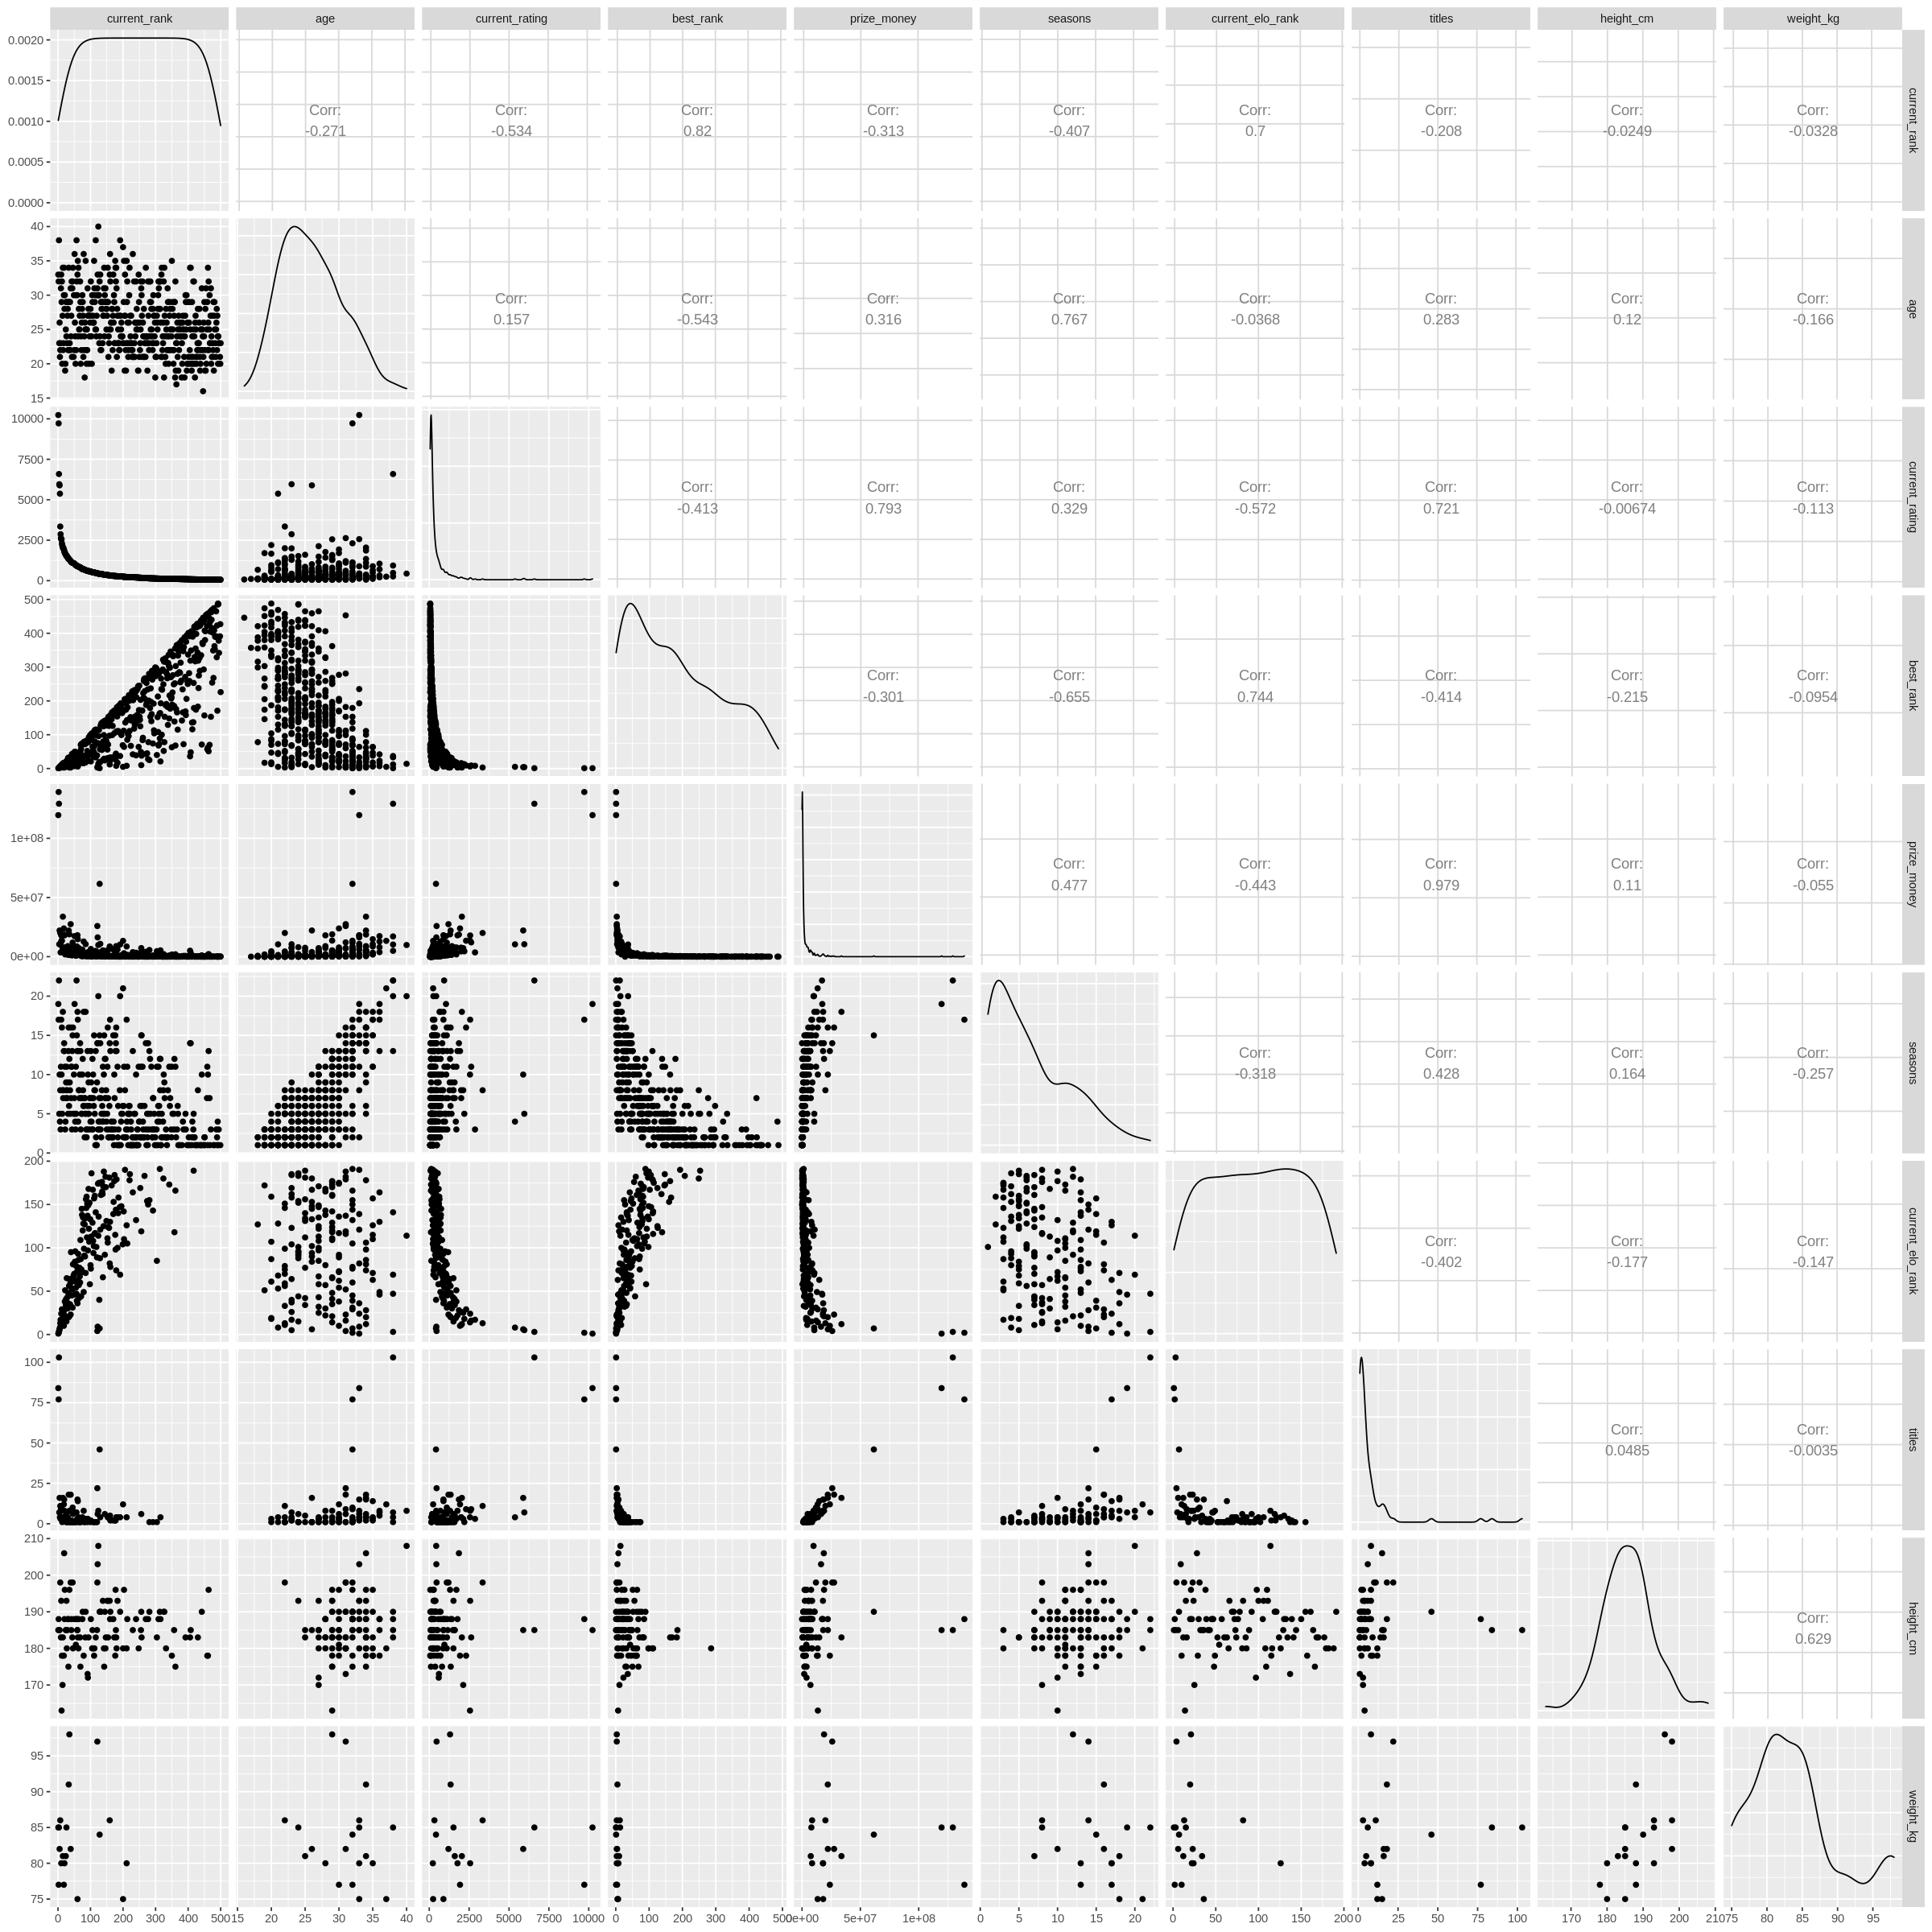

In [20]:
options(repr.plot.height = 20, repr.plot.width = 20)

ggpairs_plot <- tidy_player_stats %>%
        select(current_rank, age, current_rating, best_rank, prize_money, seasons, current_elo_rank, titles, height_cm, weight_kg) %>%
        ggpairs()
ggpairs_plot

Warning message:
“Removed 380 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 380 rows containing missing values (geom_point).”


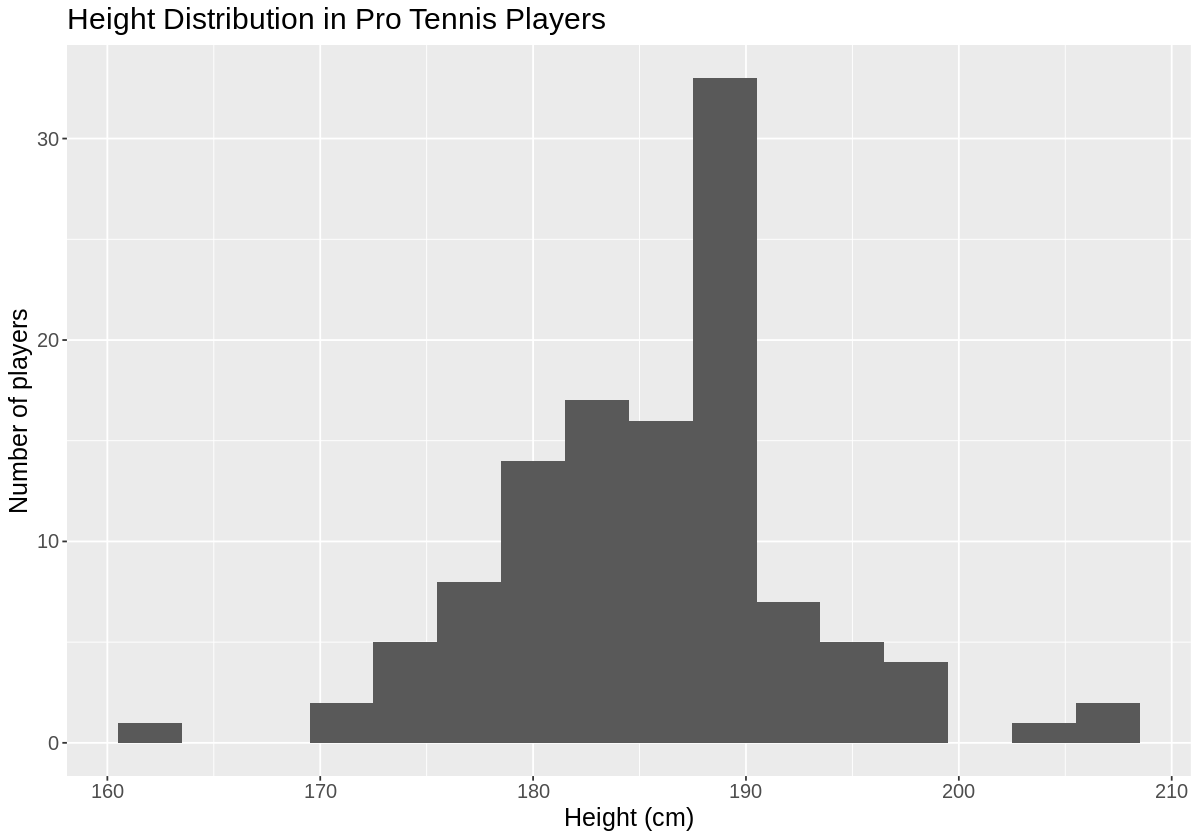

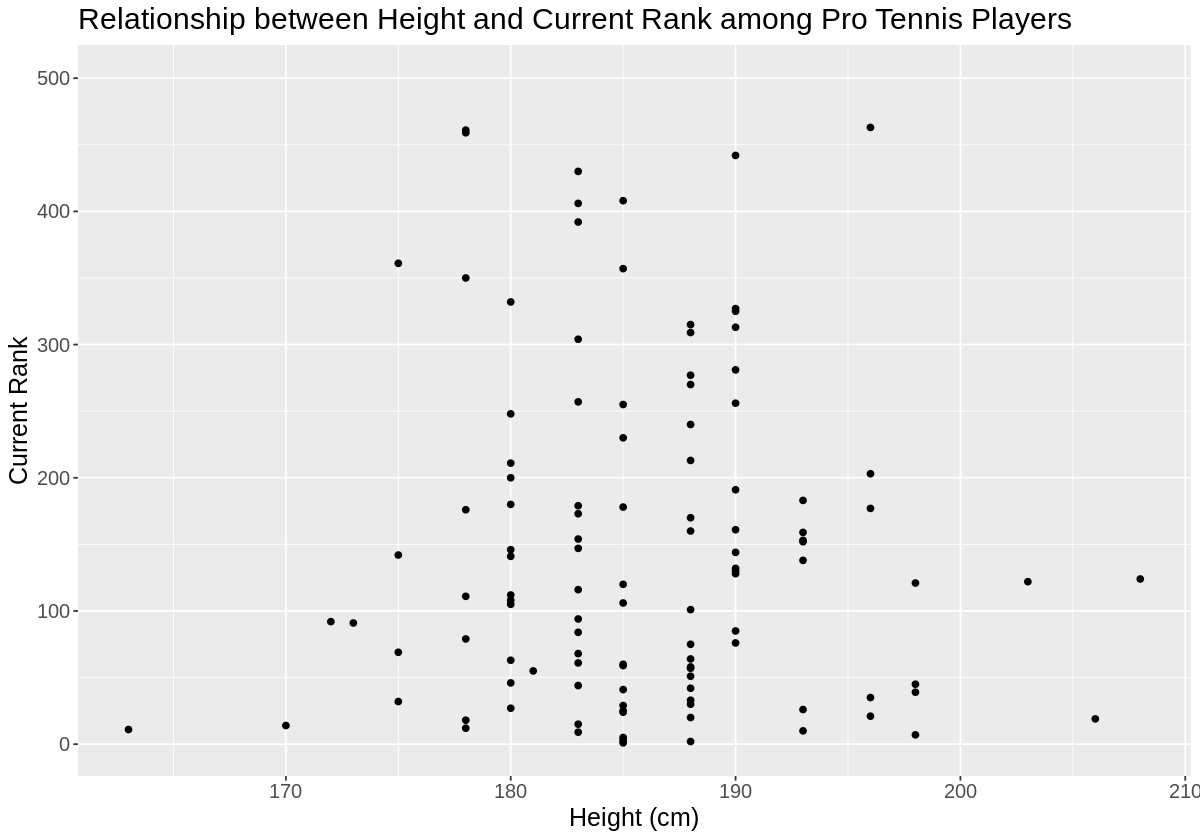

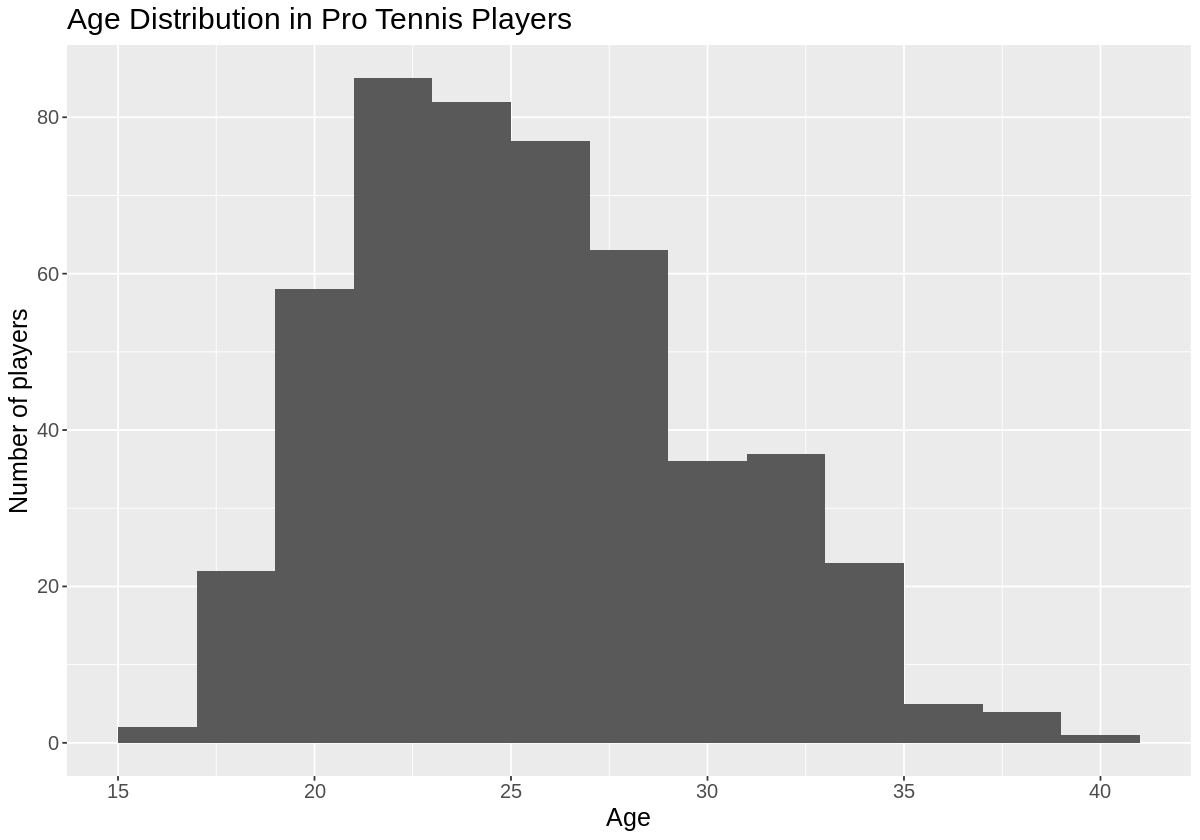

Warning message:
“Removed 311 rows containing missing values (geom_point).”


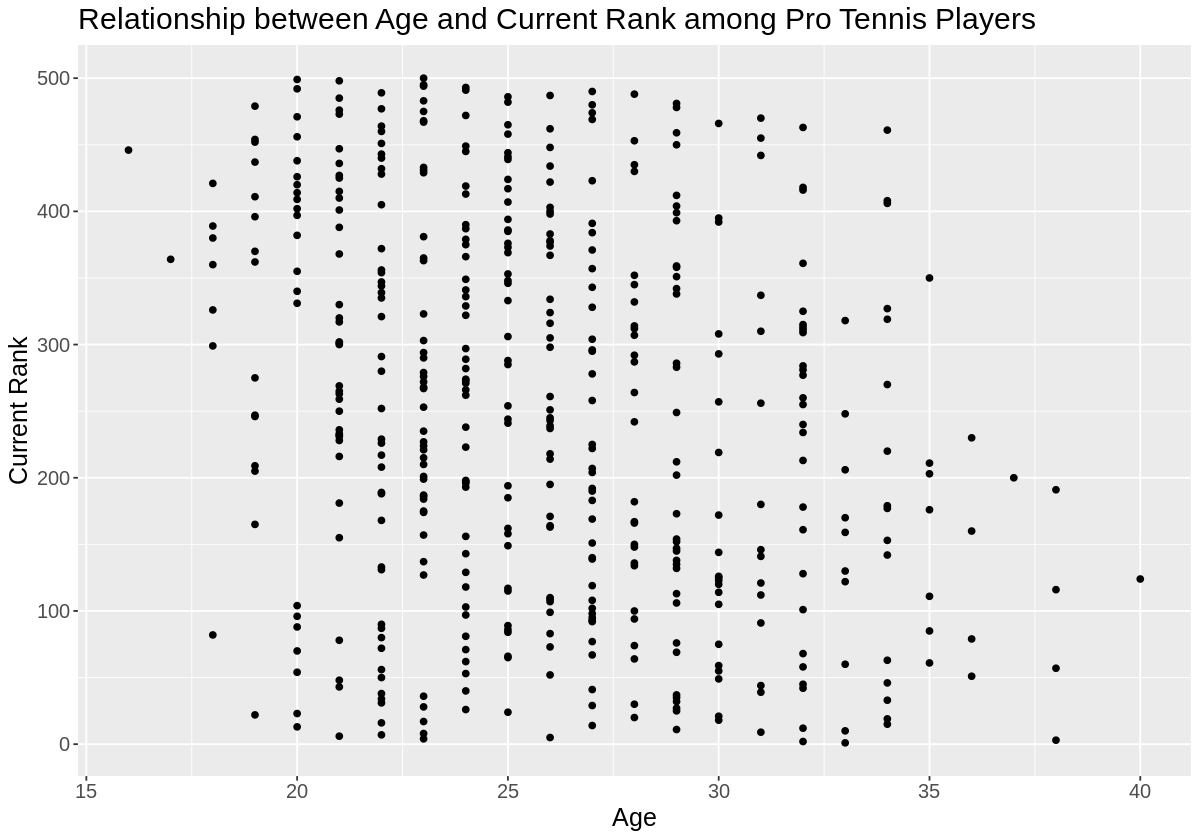

Warning message:
“Removed 394 rows containing missing values (geom_point).”


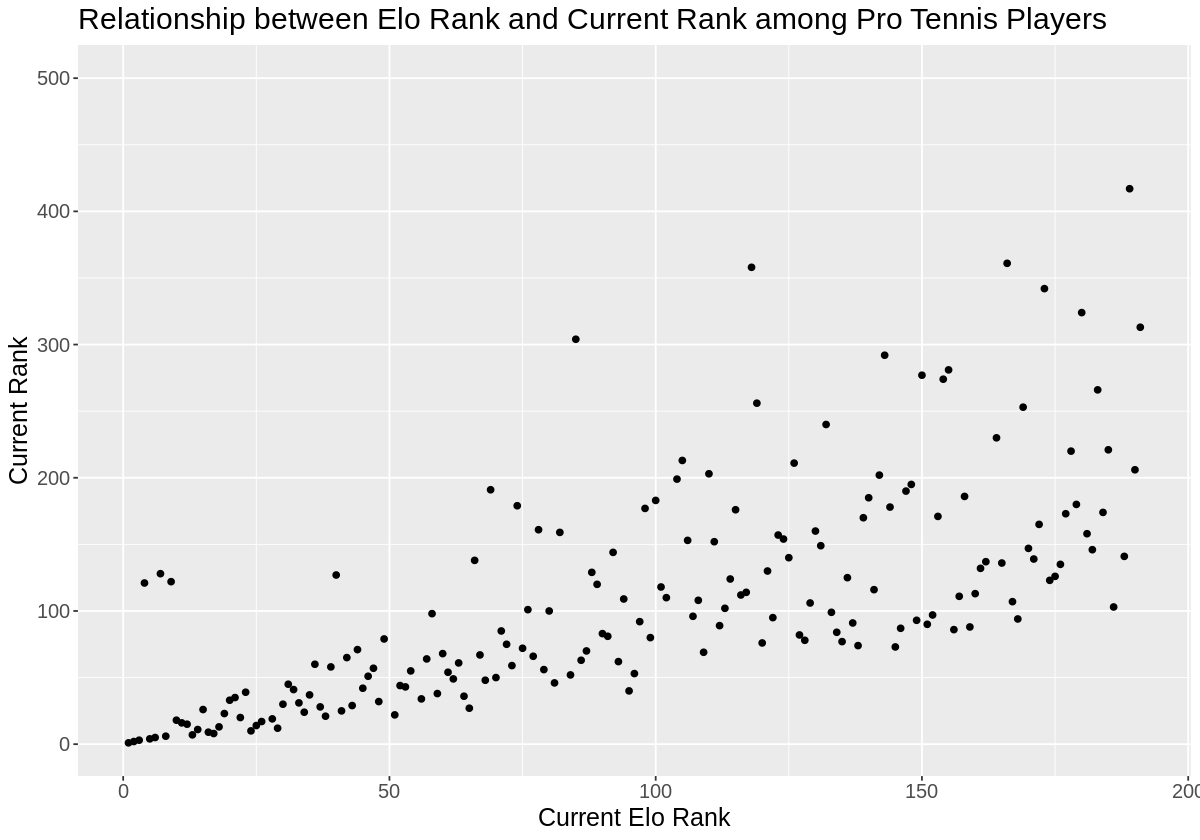

Warning message:
“Removed 122 rows containing missing values (geom_point).”


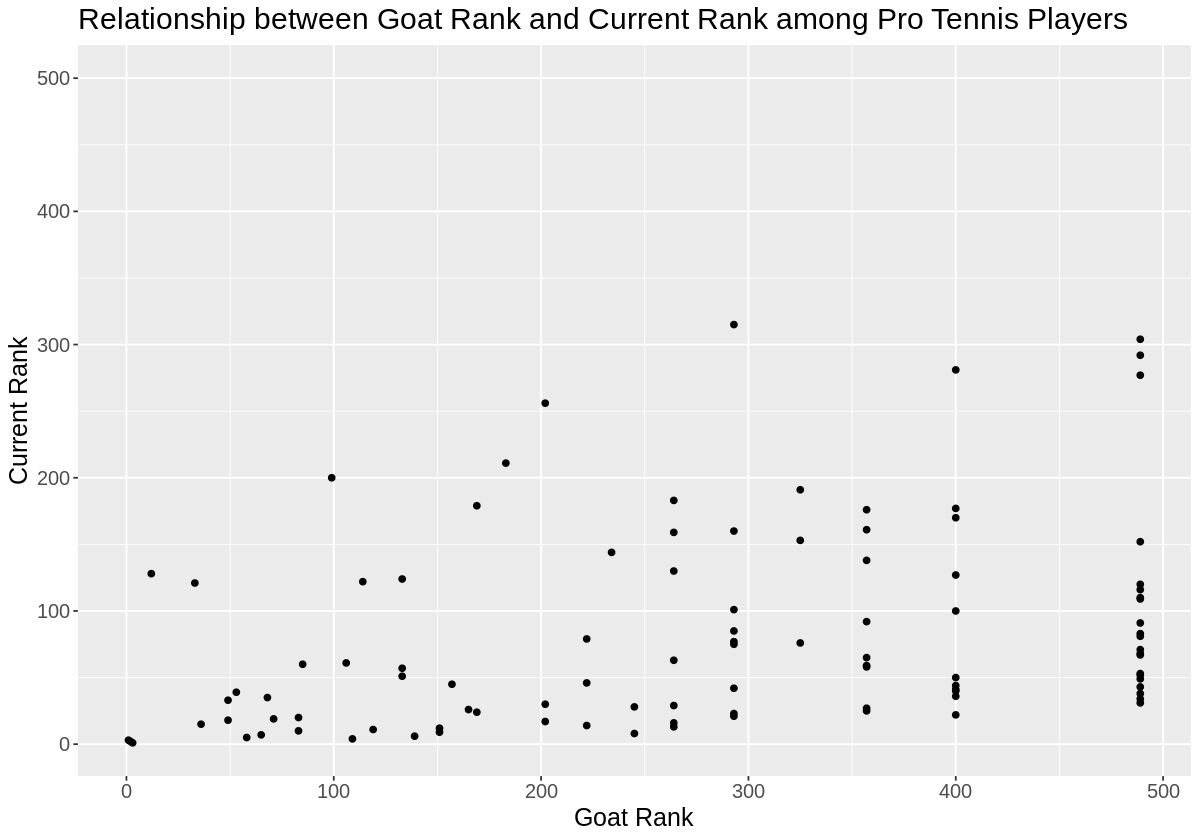

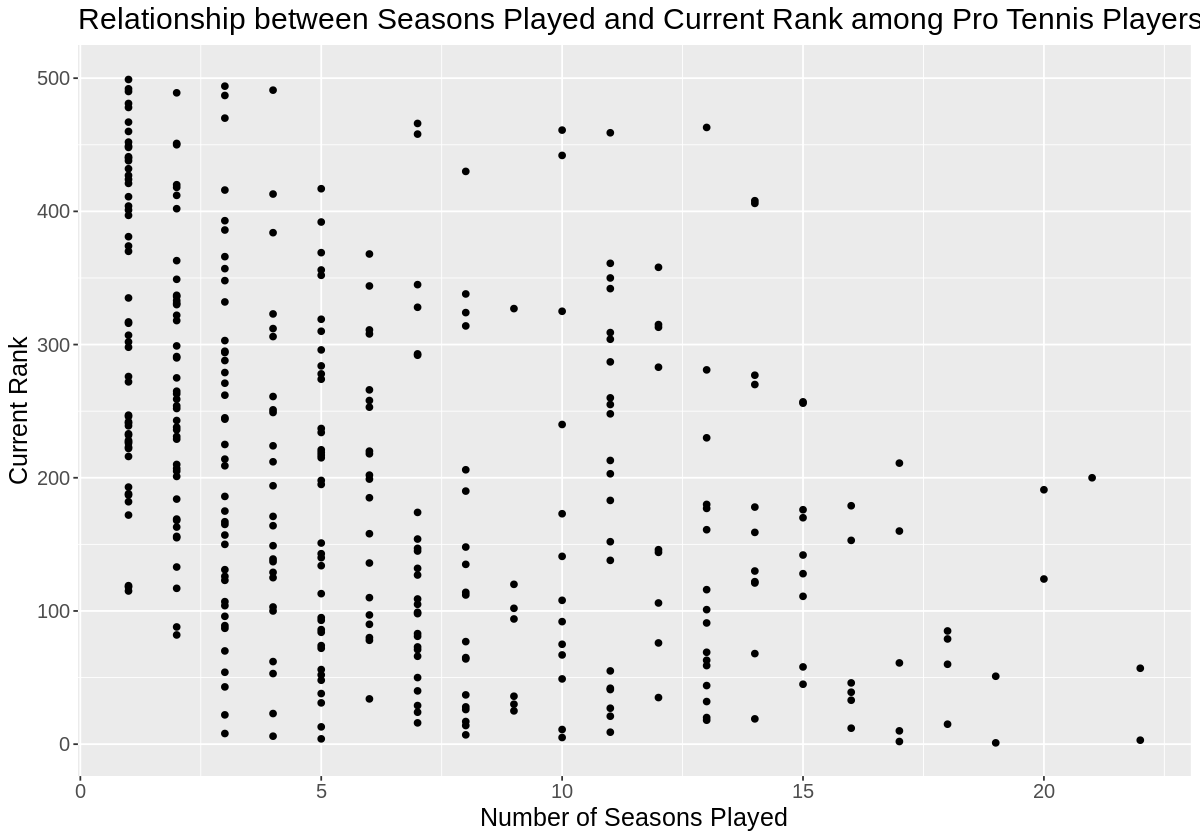

In [111]:
options(repr.plot.height = 7, repr.plot.width = 10)

hist_height <- ggplot(tidy_player_stats, aes(x = height_cm)) +
        geom_histogram(binwidth = 3) +
        labs(x = "Height (cm)", y = "Number of players", title = "Height Distribution in Pro Tennis Players") +
        theme(text = element_text(size = 15))
hist_height

rank_vs_height <- ggplot(tidy_player_stats, aes(x = height_cm, y = current_rank)) +
        geom_point() +
        labs(x = "Height (cm)", y = "Current Rank", title = "Relationship between Height and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_height

hist_age <- ggplot(tidy_player_stats, aes(x = age)) +
        geom_histogram(binwidth = 2) +
        labs(x = "Age", y = "Number of players", title = "Age Distribution in Pro Tennis Players") +
        theme(text = element_text(size = 15))
hist_age

rank_vs_age <- ggplot(tidy_player_stats, aes(x = age, y = current_rank)) +
        geom_point() +
        labs(x = "Age", y = "Current Rank", title = "Relationship between Age and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_age

rank_vs_elorank <- ggplot(tidy_player_stats, aes(x = current_elo_rank, y = current_rank)) +
        geom_point() +
        labs(x = "Current Elo Rank", y = "Current Rank", title = "Relationship between Elo Rank and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_elorank

rank_vs_goatrank <- ggplot(tidy_player_stats, aes(x = goat_rank, y = current_rank)) +
        geom_point() +
        labs(x = "Goat Rank", y = "Current Rank", title = "Relationship between Goat Rank and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_goatrank

rank_vs_seasons <- ggplot(tidy_player_stats, aes(x = seasons, y = current_rank)) +
        geom_point() +
        labs(x = "Number of Seasons Played", y = "Current Rank", title = "Relationship between Seasons Played and Current Rank among Pro Tennis Players") +
        theme(text = element_text(size = 15))
rank_vs_seasons

### Methods:

We don't plan to use all of the columns, but we will definitely examine all the rating and ranking data, the amount of titles a player has and how they correlate with age. We might also use relevant variables such as the amount of seasons they played to filter or sort our data. We will drop unnecessary columns such as 'Facebook', 'Wikipedia', and 'Nicknames'.

As can be seen with several examples above, we plan to visualize our results using labelled plots with ggplot. Both scatter plots and histograms may be used, depending on which comparisons are being made. For example, age vs rank comparison will have a scatterplot, whereas height or age distribution would be plotted with a histogram. We can then perform regression on our scatter plots to produce a generalized model or formula for the data that predicts a players performance, quantified by various rankings, versus their age. 



 
### Expected outcomes and significance:
We are comparing the players’ age with rank. We expect to find mostly non-linear, perhaps quadratic relationships between age and rank that are positive in the beginning but reach a vertex point at around age 30 and start to decrease after. As tennis is a strenuous sport, we assume that as athletes age past their physical prime, it becomes more likely for them to sustain a career ending injury before 30, retire to focus on different priorties such as starting a family, or become unable to keep up with the physical demand of the sport due to the wear and tear of muscles that come from extended use.

Most assume that the older the athlete gets, the closer they are to the end of their career. We want to see if there will be any change in this assumption, whether there are remarkable athletes at younger ages or older ages. 

This could lead to future questions such as: Do genetics have a role in whether an athlete will have a long lasting career?
Natural talent at a young age can be an indicator of a career in that field. Can natural talent lead to younger athletes obtaining higher ranks?

Our findings, which model a player's performance based on age, can be significant in many areas of the sport, from deciding age classifications at tournaments to player coaching and career planning. The data we produce can also serve as a prompt for further investigations, such as finding out why players peak at a certain age and what factors may shorten or lengthen a player’s career. 

